In [1]:
import pandas, scipy, numpy
import sklearn.ensemble
import sklearn.metrics
from IPython.display import Image

import sys
sys.path.append('./github/local-adverse-detection/')
from lad import lad

%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### Load data

In [103]:
# German credit score

#1 (bad loans) and 2 (good loans)
path_dataset='/Users/axa/Data/data-german-credit.csv'
Xraw = pandas.read_csv(path_dataset, delimiter=",", index_col=0)
y = Xraw.label
X = Xraw.iloc[:,Xraw.columns != 'label']
X = (X-X.mean())/X.std()

#### Blackbox training

In [3]:
## Train a back-box classifier on the synthetic dataset
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(X, y, test_size=0.20)

clf = sklearn.ensemble.RandomForestClassifier(n_estimators=200)
clf.fit(train, labels_train)

print(sklearn.metrics.accuracy_score(labels_test, clf.predict(test)))
print(sklearn.metrics.classification_report(labels_test, clf.predict(test)))

0.74
             precision    recall  f1-score   support

          1       0.79      0.87      0.83       143
          2       0.56      0.40      0.47        57

avg / total       0.72      0.74      0.73       200



#### Local Surrogate

In [6]:
ls = lad.LocalSurrogate(X, blackbox=clf, n_support_points=100, max_depth=3)

In [7]:
# Test on a sample

x_toexplain = X.iloc[13].copy()
#x_toexplain.iloc[1] = x_toexplain.iloc[1]+0.01
support_points, surrogate = ls.get_local_surrogate(x_toexplain)

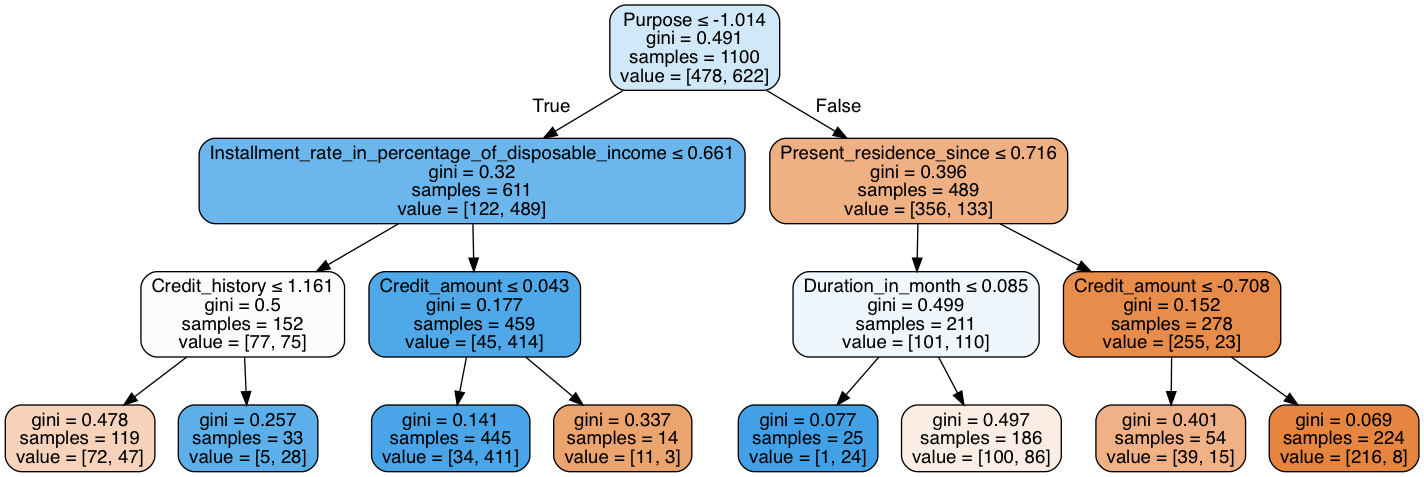

In [6]:
Image(ls.plot_decision_tree(X, surrogate))

#### Assess local surrogate fidelity

In [4]:
from scipy.spatial.distance import euclidean
from sklearn.metrics import euclidean_distances

def get_random_points_hypersphere(x_center, radius_, n_points_):

        res = []
        while len(res) < n_points_:
        
            n_points_left_ = n_points_ - len(res)
            # About half the points are lost in the test hypercube => hypersphere
            lbound = numpy.repeat([x_center.values-(radius_/2.)], n_points_left_*2, axis=0)
            hbound = numpy.repeat([x_center.values+(radius_/2.)], n_points_left_*2, axis=0)
            points = numpy.random.uniform(low=lbound, high=hbound)
            # Check if x_generated is within hypersphere (if kind=='hypersphere')
            for x_generated in points:
                if euclidean(x_generated, x_center.values) < radius_:
                    res.append(x_generated)
                if len(res) == n_points_:
                    break

        return pandas.DataFrame(numpy.array(res))
    
def surrogate_fidelity(Xtest, blackbox, surrogate, metric):
    
    ypred_blackbox = blackbox.predict(Xtest)
    ypred_surrogate = surrogate.predict(Xtest)
    return metric(ypred_surrogate, ypred_blackbox)

def growing_surrogate_fidelity(x_toexplain, X, blackbox, surrogate, metric, n_points_=100,
                              radius_perc=[0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]):
    
    dists = euclidean_distances(x_toexplain.to_frame().T, X)
    dists = pandas.Series(dists[0], index=X.index)
    radius_all_ = dists.max()*numpy.array(radius_perc)
    
    res = {}
    for i in range(len(radius_all_)):
        Xtest = get_random_points_hypersphere(x_toexplain, radius_all_[i], n_points_)
        res[radius_perc[i]] = surrogate_fidelity(Xtest, clf, surrogate, accuracy_score)
        
    return pandas.Series(res)

In [5]:
from multiprocessing import Pool
from itertools import repeat
from sklearn.metrics import accuracy_score

n_points_ = 1000
#xs_toexplain = numpy.random.choice(X.index, 12)
xs_toexplain = test.index

def multiproc(args):
    X = args[0]
    xs_toexplain = args[1]
    clf = args[2]
    i = args[3]
    print(i)
    x_toexplain = X.iloc[xs_toexplain[i]]
    ls = lad.LocalSurrogate(X, blackbox=clf, n_support_points=1000, n_segment_points=1000, max_depth=5)
    support_points, surrogate = ls.get_local_surrogate(x_toexplain)
    return growing_surrogate_fidelity(x_toexplain, X, clf, surrogate, accuracy_score, n_points_=n_points_)


with Pool(6) as p:
    args = zip(repeat(X), repeat(xs_toexplain), repeat(clf), range(len(xs_toexplain)))
    res = p.map(multiproc, args)

res_ = pandas.DataFrame({i:res[i] for i in range(len(xs_toexplain))})

0
9
18
27
36
45
1
46
37
19
28
10
2
38
47
29
20
11
39
3
48
30
21
12
40
4
22
49
31
13
41
32
23
5
50
14
42
6
51
33
24
15
43
7
25
16
52
34
44
8
26
17
35
53
54
63
72
81
90
99
55
73
64
82
91
100
56
65
74
83
92
101
57
66
75
93
84
102
58
76
67
94
85
103
59
77
68
95
104
86
60
78
96
69
105
87
61
79
70
106
97
88
62
80
107
71
98
89
108
117
126
135
144
153
118
109
127
136
145
154
110
119
137
128
146
155
111
138
120
147
129
156
112
121
139
148
130
157
113
140
122
149
131
158
123
114
141
150
132
159
124
151
142
115
133
160
125
143
152
116
134
161
162
171
180
189
198
163
181
172
190
199
164
173
182
191
165
183
174
192
166
184
175
193
167
185
176
194
168
186
195
177
169
187
178
196
170
188
197
179


In [39]:
"""
from sklearn.metrics import accuracy_score

n_points_ = 1000
xs_toexplain = numpy.random.choice(X.index, 100)

res_ = {}
for i in range(len(xs_toexplain)):
    print(i)
    x_toexplain = X.iloc[xs_toexplain[i]]
    ls = lad.LocalSurrogate(X, blackbox=clf, n_support_points=100, max_depth=3)
    support_points, surrogate = ls.get_local_surrogate(x_toexplain)
    res_[i] = growing_surrogate_fidelity(x_toexplain, X, clf, surrogate, accuracy_score, n_points_=n_points_)
    
res_ = pandas.DataFrame(res_)
"""

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


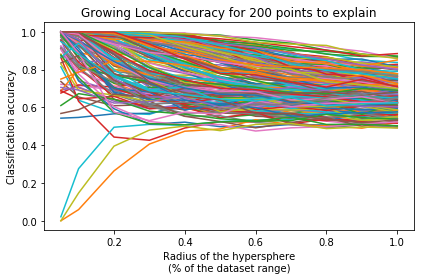

In [6]:
for j in res_.columns:
    plot(res_.iloc[:,j])
title('Growing Local Accuracy for '+str(len(xs_toexplain))+' points to explain')
xlabel('Radius of the hypersphere\n(% of the dataset range)')
ylabel('Classification accuracy')
tight_layout()
savefig('/Users/axa/Desktop/ECML_adversarial/local_fidelity.png')
savefig('/Users/axa/Desktop/ECML_adversarial/local_fidelity.pdf')

In [7]:
df = res_.copy()

In [8]:
dic = {}
c = 0
for j in range(df.shape[1]):
    for i in range(df.shape[0]):
        dic[c] = pandas.Series([df.iloc[i,j], df.index[i]], index=['accuracy','perc'])
        c += 1

In [9]:
dic = pandas.DataFrame(dic).T

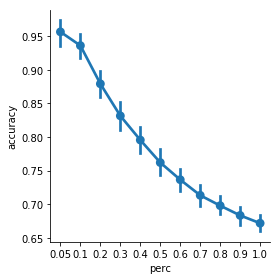

In [10]:
import seaborn as sns
g = sns.factorplot(x="perc", y="accuracy", data=dic)

savefig('/Users/axa/Desktop/ECML_adversarial/local_fidelity_agg.png')
savefig('/Users/axa/Desktop/ECML_adversarial/local_fidelity_agg.pdf')

In [64]:
df_localsurr = pandas.read_csv('./results/tables/exp1_german_localsurr5.csv', index_col=0)
df_papernot = pandas.read_csv('./results/tables/exp1_german_papernot.csv', index_col=0)

In [65]:
df = df_localsurr.copy()
df = df.T
dic = {}
c = 0
for j in range(df.shape[1]):
    for i in range(df.shape[0]):
        dic[c] = pandas.Series([df.iloc[i,j], df.index[i], 'LAD'], index=['Local Fidelity','Hypersphere radius (% of max distance)', 'Algorithm'])
        c += 1

df = df_papernot.copy()
df = df.T
for j in range(df.shape[1]):
    for i in range(df.shape[0]):
        dic[c] = pandas.Series([df.iloc[i,j], df.index[i], 'Papernot2017'], index=['Local Fidelity', 'Hypersphere radius (% of max distance)', 'Algorithm'])
        c += 1

dic = pandas.DataFrame(dic).T

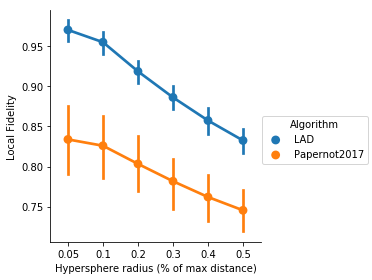

In [165]:
g = sns.factorplot(x='Hypersphere radius (% of max distance)', y='Local Fidelity', hue='Algorithm', data=dic)
savefig('/Users/axa/Desktop/ECML_adversarial/local_fidelity_agg.png')
savefig('/Users/axa/Desktop/ECML_adversarial/local_fidelity_agg.pdf')

array([1])

In [96]:
f = 'Age_in_years'
Xraw.loc[:,f].mean()
Xraw.loc[:,f].std()

35.546

In [157]:
import pickle

blackbox = pickle.load( open( "../../bb_model.p", "rb" ) )
adversarials = pickle.load( open( "../../adversarials.p", "rb" ) )

In [159]:
blackbox

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [164]:
i = 0
p1 = adversarials[i][0]
p2 = adversarials[i][1]
get_normed_direction(p1, p2)

5    -0.428607
3     0.369861
13   -0.346163
14   -0.293227
1     0.288446
16   -0.261688
8    -0.243412
11    0.220382
19    0.214222
9    -0.201092
6    -0.193250
2    -0.136363
0    -0.132964
15   -0.132040
7     0.131085
10    0.074931
4     0.070118
17   -0.067281
12   -0.051360
18   -0.043894
dtype: float64

In [153]:
me = Xraw.loc[:,f].mean()
st = Xraw.loc[:,f].std()

i = 947
x = X.loc[[i]].copy()
print(clf.predict(x))
f = 'Other_debtors_guarantors'
x.loc[i,f] = (1-me)/st
print(clf.predict(x))

"""
x = X.loc[[i]].copy()
f = 'Number_of_existing_credits_at_this_bank'
x.loc[i,f] = (1-Xraw.loc[:,f].mean())/Xraw.loc[:,f].std()
print(clf.predict(x))
x = X.loc[[i]].copy()
f = 'Personal_status_and_sex'
x.loc[i,f] = (2-Xraw.loc[:,f].mean())/Xraw.loc[:,f].std()
f = 'Age_in_years'
x.loc[i,f] = (82-Xraw.loc[:,f].mean())/Xraw.loc[:,f].std()
print(clf.predict(x))
"""

[1]
[1]
[1]
[1]
[1]


"\nx = X.loc[[i]].copy()\nf = 'Number_of_existing_credits_at_this_bank'\nx.loc[i,f] = (1-Xraw.loc[:,f].mean())/Xraw.loc[:,f].std()\nprint(clf.predict(x))\nx = X.loc[[i]].copy()\nf = 'Personal_status_and_sex'\nx.loc[i,f] = (2-Xraw.loc[:,f].mean())/Xraw.loc[:,f].std()\nf = 'Age_in_years'\nx.loc[i,f] = (82-Xraw.loc[:,f].mean())/Xraw.loc[:,f].std()\nprint(clf.predict(x))\n"

In [163]:
def get_normed_direction(p1, p2):
    v = p2-p1
    d = v/numpy.linalg.norm(v)
    return d.loc[d.map(lambda x : x).abs().sort_values(ascending = False).index]

In [81]:
get_norm_direction(X.iloc[1], X.iloc[0])

Age_in_years                                                0.513014
Duration_in_month                                          -0.451680
Savings_account_bonds                                       0.328309
Telephone                                                   0.264153
Credit_history                                              0.239464
Present_residence_since                                     0.234995
Installment_rate_in_percentage_of_disposable_income         0.231845
Number_of_existing_credits_at_this_bank                     0.224501
Credit_amount                                              -0.219698
Present_employment_since                                    0.214654
Personal_status_and_sex                                     0.183149
Status_of_existing_checking_account                        -0.103117
Purpose                                                     0.000000
foreign_worker                                              0.000000
Property                          

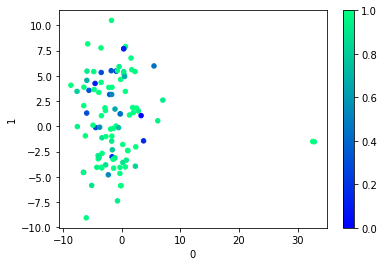

In [46]:
from sklearn.manifold import Isomap
iso = Isomap(n_components=2)
iso = iso.fit(X)

X_embedded = iso.transform(X.iloc[xs_toexplain])

df_ = res_.copy()
df_.columns = X.iloc[xs_toexplain].index

f, ax = subplots(1)
df = pandas.DataFrame(X_embedded)

df.plot(kind='scatter', x=0, y=1, c=df_.loc[0.1], ax=ax, colormap='winter')

#### Give some insights with provided explanation for potential adverse

#### Check explanations (ie. given an adverse generated from a true point, fit the local surrogate to oberse features)